In [39]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy
from sklearn.ensemble import RandomForestRegressor
import torch.nn as nn
import shap
import seaborn as sns
sns.set_theme(style="white")

In [40]:
# Setting variables
N = 100  # Number of samples
D = 10  # Number of features
seed = 1

In [41]:
np.random.seed(seed)

In [42]:
# To generate samples from Bernoulli Distribution we will use np.random.binomial as If you pass n=1 to the Binomial distribution it is equivalent to the Bernoulli distribution.
# Ref: https://stackoverflow.com/questions/47012474/bernoulli-random-number-generator#:~:text=If%20you%20pass%20n%3D1%20to%20the%20Binomial%20distribution%20it%20is%20equivalent%20to%20the%20Bernoulli%20distribution.

# Generate samples
samples = np.random.binomial(1, 0.5, (N, D))

In [43]:
# Helper for generating feature column name in dataframe.
cols= []
for i in range(1, 11):
    cols.append(f'feature_{i}') 

In [44]:
generated_data = pd.DataFrame(samples, columns=cols)

In [45]:
generated_data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,0,1,0,0,0,0,0,0,0,1
1,0,1,0,1,0,1,0,1,0,0
2,1,1,0,1,1,1,0,0,0,1
3,0,0,1,1,1,0,1,1,0,1
4,1,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,0,0,0,1,0,0,1
96,1,1,1,1,0,0,0,0,1,0
97,1,1,0,1,0,0,0,1,0,1
98,0,0,1,0,0,1,1,0,1,1


In [46]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(3, 2)
        self.fc2 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

        # Set the weights
        with torch.no_grad():
            self.fc1.weight.fill_(1)
            self.fc2.weight.fill_(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the network
net321 = SmallNet()

In [47]:
# Test the network with a random input
input = torch.tensor(generated_data.iloc[:, :3].values, dtype=torch.float32)
output = net321(input)
generated_data.loc[:, 'output'] = output.detach().numpy()

In [48]:
generated_data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,output
0,0,1,0,0,0,0,0,0,0,1,2.297542
1,0,1,0,1,0,1,0,1,0,0,2.297542
2,1,1,0,1,1,1,0,0,0,1,4.297542
3,0,0,1,1,1,0,1,1,0,1,2.297542
4,1,1,0,1,0,0,1,0,0,0,4.297542
...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,0,0,0,1,0,0,1,2.297542
96,1,1,1,1,0,0,0,0,1,0,6.297542
97,1,1,0,1,0,0,0,1,0,1,4.297542
98,0,0,1,0,0,1,1,0,1,1,2.297542


In [49]:
generated_data.shape

(100, 11)

In [50]:
training_data = generated_data.iloc[:int(0.8*generated_data.shape[0]),:]
test_data = generated_data.iloc[int(0.8*generated_data.shape[0]):, :]

In [51]:
training_data.shape

(80, 11)

In [52]:
test_data.shape

(20, 11)

In [53]:
X_train = training_data.iloc[:, :-1]
y_train = training_data.iloc[:, -1:]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1:]

In [54]:
regressor = RandomForestRegressor()

In [55]:
regressor.fit(X_train.values, y_train.values.ravel())

RandomForestRegressor()

In [56]:
y_predicted = regressor.predict(X_test.values)

In [57]:
y_predicted

array([4.33754162, 2.29754186, 4.33754162, 4.29754162, 0.29754171,
       6.29754162, 2.29754186, 0.29754171, 2.29754186, 0.29754171,
       2.29754186, 4.29754162, 0.29754171, 0.31754171, 0.31754171,
       2.29754186, 6.29754162, 4.25754162, 2.29754186, 4.29754162])

In [58]:
test_pcc = scipy.stats.pearsonr(y_predicted, y_test.values.ravel())

In [59]:
test_pcc

PearsonRResult(statistic=0.999965684978831, pvalue=6.263971646928201e-39)

In [60]:
# Calculating shap values for each test example
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test.values)

In [61]:
shap_values.shape

(20, 10)

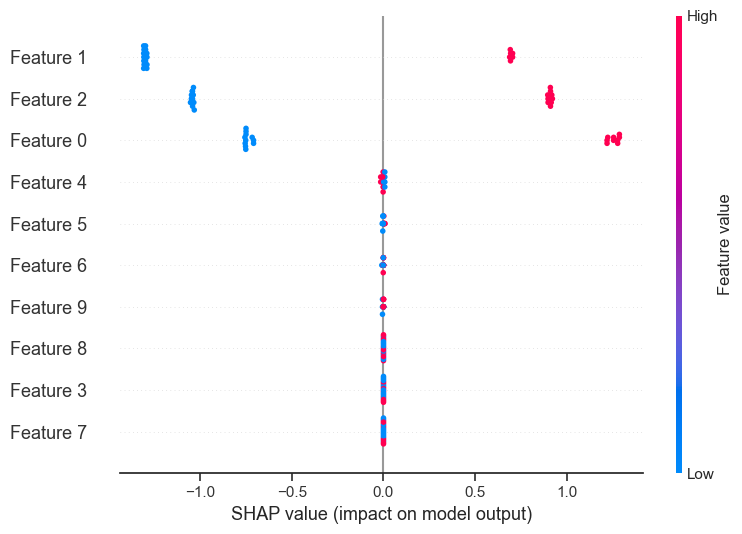

In [62]:
shap.summary_plot(shap_values, X_test.values)

In [63]:
mean_shap_values = (1/shap_values.shape[0])*np.abs(shap_values).sum(axis=0)

In [64]:
mean_shap_values.shape

(10,)